In [14]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pickle
rng = np.random.default_rng(42)

## Q1. Use Approximate Bayesian Computation (ABC) to learn the hyperparameters of a Gaussian Process.
### This is a hard problem, so we are going to use a small dataset:

In [20]:
with open("data_ps6.pkl", "rb") as f:
    xs, ys = pickle.load(f)

### Define the matern 3/2 kernel, and draw from the priors over the two parameters of GP: xi and sigma^2
#### (adapted from Hogg code)

In [100]:
def mk(xs1, xs2, sigma_sq, xi):
    d = np.subtract.outer(xs1, xs2) #distances
    return sigma_sq * ((1+(np.sqrt(3))*d/xi) * np.exp(-np.sqrt(3*d*d)/xi))

def draw(pars, rng=rng): #flat priors
    sigma_sq = pars[0] + (pars[1] - pars[0]) * rng.uniform()
    xi = pars[2] + (pars[3] - pars[2]) * rng.uniform()
    return sigma_sq, xi

def simulate(xs, pars, rng=rng):
    sigma_sq, xi = draw(pars, rng=rng)
    var = mk(xs, xs, sigma_sq, xi)
    return sigma_sq, xi, rng.multivariate_normal(0. * xs, var) #K is truly a variance!

C:\Users\ajati\AppData\Local\Temp\ipykernel_10460\439360285.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  return sigma_sq, xi, rng.multivariate_normal(0. * xs, var)


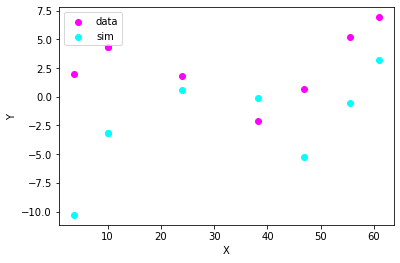

In [30]:
#run the simulation
prior_pars = np.array([10., 100., 1., 10.])
sigma_sq, xi, ysim = simulate(xs, prior_pars)

fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o', c = 'magenta', label = 'data')
ax.scatter(xs, ysim, marker = 'o', c = 'cyan', label = 'sim')
ax.legend()
ax.set_xlabel('X')
_=ax.set_ylabel('Y')

### So far, so good...so what?
### Now, run this simulation many many times and pick the simulations for which some criterion is satisfied

In [114]:
def ABC(xs, ys, pars, eps):
    #run the simulation 
    sigma_sq, xi, ysim = simulate(xs, pars)
    res = res_out(ys, ysim)
    accept = False
    if res < eps:
        accept = True
    return accept, sigma_sq, xi
    
def res_out(y, yhat): #compute the l2 norm, and average
    res = [(y[i]**2 + yhat[i]**2)**1/2 for i in range(len(y))]
    return np.mean(res)

def fullABC(xs, ys, pars, eps0, N): #start with a large epsilon eps0
    eps = eps0
    n = 0
    scale = 2 #a scaling factor
    num_accept = 0 #keep track of number of acceptances
    sigma_sq_list = []
    xi_list = []
    eps_list = []
    while n<N:
        if (n+1)%5000 == 0:
            print('{}-th iteration'.format(n))
        accept, sigma_sq, xi = ABC(xs, ys, pars, eps)
        if accept:
            eps/=2 #make the threshold even smaller if accepted
            #we want to make priors become more and more constrained. Choose the larger or smaller between two
                #options depending on limits
            p0, p1, p2, p3 = pars[0], pars[1], pars[2], pars[3]
            p0 = max(pars[0], xi-sigma_sq*scale)
            p1 = min(pars[1], xi+sigma_sq*scale)
            p2 = max(pars[2], xi-sigma_sq*scale)
            p3 = min(pars[3], xi+sigma_sq*scale)
            pars = np.array([p0, p1, p2, p3])
            num_accept += 1
        else: 
            eps*=1.05 #else, make threshold bigger
        n += 1
        sigma_sq_list.append(sigma_sq)
        xi_list.append(xi)
        eps_list.append(eps)
    return eps_list, sigma_sq_list, xi_list

C:\Users\ajati\AppData\Local\Temp\ipykernel_10460\4041756349.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  return sigma_sq, xi, rng.multivariate_normal(0. * xs, var) #K is truly a variance!


4999-th iteration
9999-th iteration
14999-th iteration
19999-th iteration


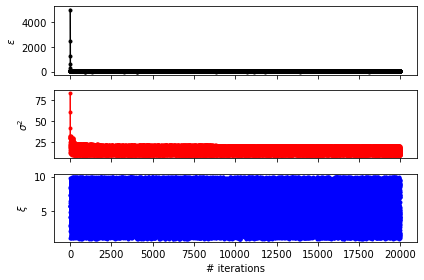

In [115]:
N = 20000
eps_list, sigma_sq_list, xi_list = fullABC(xs, ys, np.array([10., 100., 1., 10.]), 10000, N)
fig, [ax0, ax1, ax2] = plt.subplots(3, sharex = True)
ax2.set_xlabel('# iterations')
ax0.plot(np.arange(N), eps_list, 'k.-')
ax1.plot(np.arange(N), sigma_sq_list, 'r.-')
ax2.plot(np.arange(N), xi_list, 'b.-')
ax0.set_ylabel(r'$\epsilon$')
ax1.set_ylabel(r'$\sigma^{2}$')
ax2.set_ylabel(r'$\xi$')
plt.tight_layout()